# Isolated Speech Recognition Exploratory Data Analysis

In [20]:
import os
from tqdm import tqdm # This allows you to wrap any iterable in python and it then creates a progress bar for you within jupyter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

from scipy.fftpack import fft
from scipy import signal as sgn

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

%matplotlib inline

# python speech features is an audio library
from python_speech_features import mfcc, logfbank

# This is the common audio library
import librosa

### Helper Functions

1. plot_signals - Plots time series signals in a grid layout.
2. plot_fft - Plots Fourier transforms of signals in a grid layout.
3. plot_fbank - plot_fbank - Plots Filter Bank Coefficients in a grid layout.
4. plot_mfccs - Plots Mel Frequency Cepstrum Coefficients in a grid layout.
5. calc_fft - Calculates the Fast Fourier Transform (FFT) of a signal and returns its magnitude and frequency components.
6. envelop - Detects the estimation of the magnitude (amplitude) of a signal and applies noise forward detection.

In [21]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = sgn.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [22]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            if(x == 1 and y == 4):
                break
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [23]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            if(x == 1 and y == 4):
                break
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [24]:
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            if(x == 1 and y == 4):
                break
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [25]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            if(x == 1 and y == 4):
                break
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [26]:
# FFT has two parts (magnitude and frequency)
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate) # This goes to the x-axis with the spaces between the samples (d)
    Y = abs(np.fft.rfft(y)/n) # Generate the magnitude - This is the y-axis. Normalize the length of the signal by dividing by n
    return (Y, freq)

In [27]:
# Function to detect the estimation of the magnitude i.e. the Amplitude of the signal i.e. if the amplitude is too low
# then it can be stripped off since the audio has died out
# Basically to do Noise Forward Detection of the signal
def envelop(y,rate,threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10),min_periods=1,center=True).mean()
    
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
            
    return mask

### Import the CSV File

In [28]:

# Get the current working directory
cwd = os.getcwd()

# Go one folder back
parent_dir = os.path.dirname(cwd)

# Specify the relative path to the audio file from the parent directory
relative_path = r"Dataset\HindiDigitsMFCC\Train.csv"
speech_df = pd.read_csv(os.path.join(parent_dir, relative_path))
Speech_df_raw = speech_df
speech_df = speech_df.iloc[:,1:15]

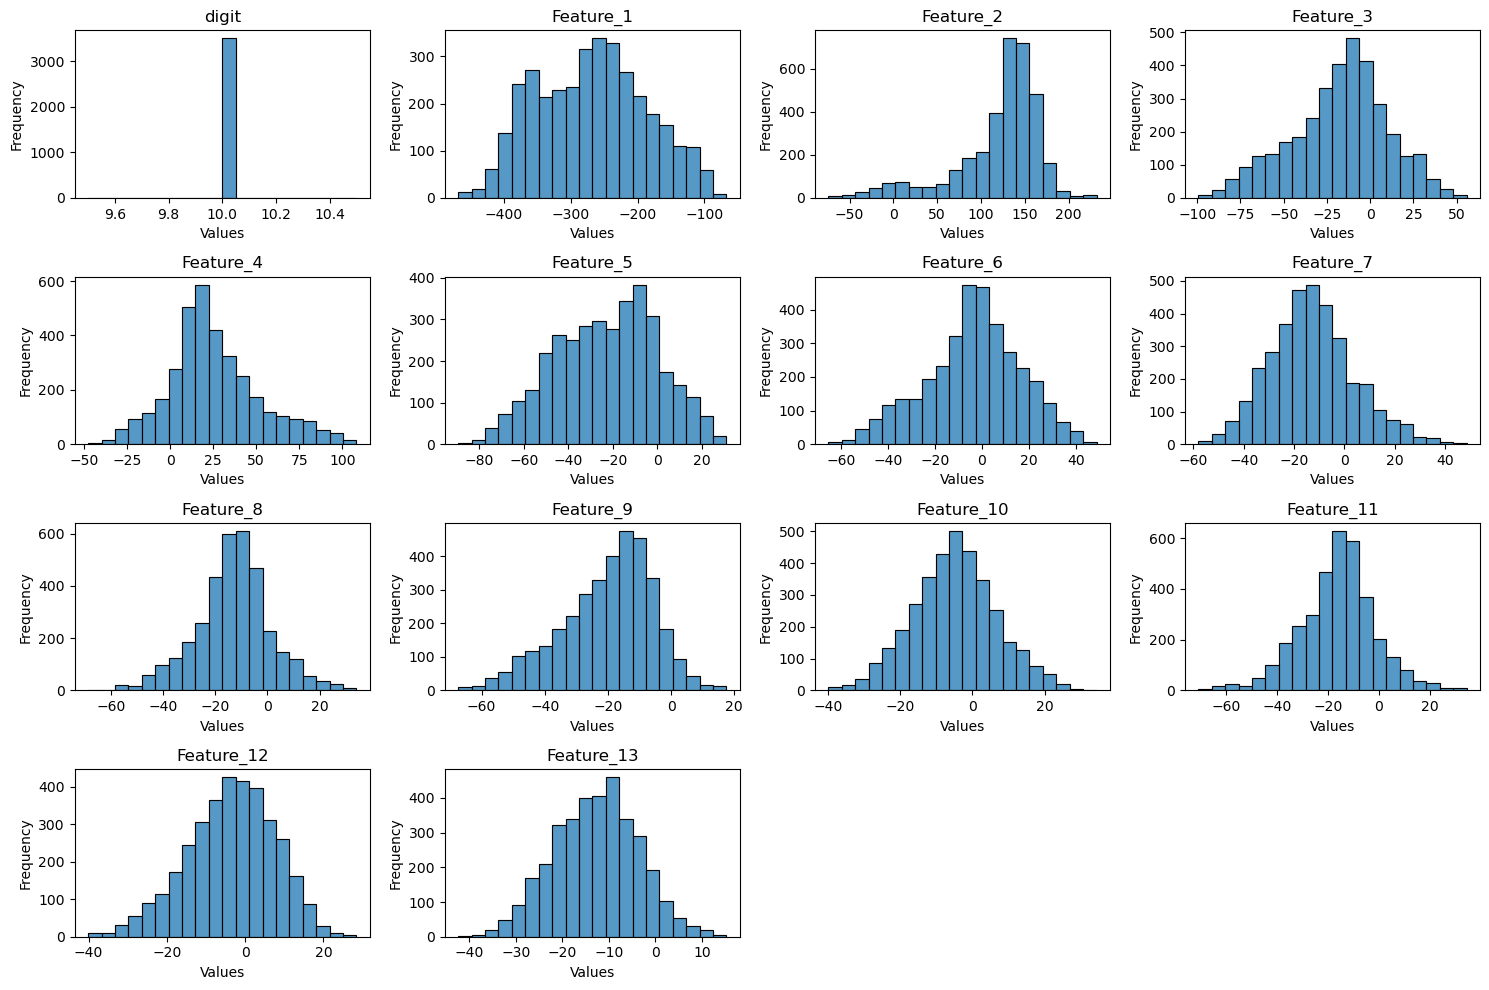

In [29]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out the deprecated function warning
warnings.filterwarnings("ignore", message="`distplot` is a deprecated function and will be removed in seaborn v0.14.0")
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated and will be removed in a future version")


# Assuming speech_df is your DataFrame

# Calculate mean and variance
mean_values = speech_df.mean()
variance_values = speech_df.var()

# Create a DataFrame to hold mean and variance
stats_df = pd.DataFrame({'Mean': mean_values, 'Variance': variance_values})

# Plot each feature on a different subplot
num_cols = speech_df.shape[1]  # Number of columns in the DataFrame

plt.figure(figsize=(15, 10))
for i, col in enumerate(speech_df.columns):
    plt.subplot(4, 4, i + 1)  # Creating a subplot
    sns.histplot(speech_df[col], kde=False, bins=20)  # Plotting the distribution of each feature
    plt.title(col)  # Setting the title of the subplot
    plt.xlabel('Values')  # Labeling x-axis
    plt.ylabel('Frequency')  # Labeling y-axis
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [30]:
speech_df.describe()

,digit,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13
count,3501.0,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000
mean,10.0,-268.652296,120.057019,-17.458267,25.464984,-22.910629,-3.773075,-13.006829,-13.152358,-20.172754,-4.807643,-16.248657,-3.637618,-12.749866
std,0.0,81.845606,48.752266,27.896829,26.717673,22.984729,20.218366,16.766546,14.393629,14.562596,11.611241,14.794266,11.166982,9.042146
min,10.0,-468.603150,-74.258470,-99.313720,-47.622894,-89.539474,-65.357254,-58.066273,-68.727910,-67.421005,-39.934700,-70.980790,-40.084100,-42.339237
25%,10.0,-336.133540,104.087430,-34.688915,9.503229,-40.413685,-15.642424,-24.263924,-20.888690,-29.077310,-12.413015,-24.474250,-11.079697,-19.191078
50%,10.0,-267.001980,133.707550,-14.456284,21.267220,-21.588572,-2.640977,-13.483070,-12.591295,-17.814552,-4.895172,-15.258269,-3.084865,-12.460665
75%,10.0,-210.756900,151.006740,0.516635,39.631195,-5.907830,9.612833,-3.243710,-5.016196,-9.701030,2.414162,-7.863914,4.313081,-6.446898
max,10.0,-66.928116,231.664100,55.693580,108.202965,31.011250,48.715034,48.559900,34.093500,17.517397,34.392982,34.455795,28.405464,15.275049


### Checkout sample data from the CSV file

In [31]:
speech_df.sample(10)

,digit,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13
2240,10,-295.15436,96.349520,-2.699843,49.798008,-12.119622,7.500773,-17.793146,0.473634,-37.898790,-17.855799,-25.584377,6.700288,-21.121452
2713,10,-362.71790,139.491130,-16.070810,5.928184,-23.669239,-3.015160,6.808418,-5.829678,4.105570,13.538322,5.230618,7.920177,6.558105
844,10,-195.01796,119.240590,-23.441235,46.639328,-35.240677,15.021069,-15.857229,-32.189030,-45.991920,-21.798710,-27.953220,0.803222,-22.602050
3238,10,-349.75200,154.164580,-7.419621,36.819550,-5.246840,-19.188343,-17.649403,-7.889950,-21.330930,-13.544174,-12.418388,-13.537897,-24.059694
2540,10,-308.22894,112.932556,26.372276,24.458910,-27.093227,34.644380,-25.528557,-22.780119,-14.472904,-14.486820,-19.528782,-5.634127,-24.620304
1207,10,-237.73228,72.762550,-16.640390,71.101300,-4.771996,-19.224980,-28.527650,12.244638,-40.337570,-10.173658,-17.806269,-11.229700,-18.533415
1718,10,-178.32664,150.674450,-41.088886,27.639944,-38.122375,-10.678633,2.512263,-39.506992,-38.916306,-8.929680,8.214037,7.584077,-23.698770
117,10,-177.71738,125.291985,-57.299576,10.169394,-7.183874,-22.895742,-35.720980,-7.677659,-56.887220,0.786291,9.406361,-14.857258,-10.295098
1963,10,-251.03308,175.961330,-12.548679,-6.990740,-46.094425,-20.622826,-23.973076,-0.410669,-22.063766,-4.575809,-19.568977,-4.318522,-7.333011
1090,10,-242.55050,129.684710,-20.707458,38.474495,-23.195164,-35.792107,-12.534859,-5.423404,-50.468910,-4.332674,-15.709886,-24.113110,-21.034576


In [32]:
import pandas as pd

# Assuming df is your DataFrame with columns ['filename', 'label', 'mfcc1', 'mfcc2', ..., 'mfcc39']

# Group the DataFrame by the label column
grouped = speech_df.groupby('digit')

# Dictionary to store the average length of features for each label
avg_lengths = {}

# Calculate the average length of features for each label
for label, group in grouped:
    # Calculate the total number of rows for the label
    total_rows = len(group)
    
    # Calculate the total length of features for the label
    total_length = sum(group.iloc[:, 2:].apply(lambda x: len(x.dropna()), axis=1))
    
    # Calculate the average length of features
    avg_length = total_length / total_rows
    
    # Store the average length of features for the label
    avg_lengths[label] = avg_length

# Print the average lengths for each label
for label, avg_length in avg_lengths.items():
    print(f"Label: {label}, Average Length of Features: {avg_length}")


Label: 10, Average Length of Features: 12.0


### Visualisations of the Time Series & FFTs, Filter Banks and MFCCs

In [35]:
# Create the dictionaries to store the data
signals = {}
fft = {}
fbank = {}
mfccs = {}

# Create dictionaries to hold the cleaned data
cleaned_signals = {}
cleaned_fft = {}
cleaned_fbank = {}
cleaned_mfccs = {}

### Generate Time Series

In [36]:
import librosa
# For each of the classes, get one audio file and plot
signals = {}
for digit in range(1,10):
    # wav_file = os.path.join(parent_dir, digit, relative_path)
    relative_path = r"Dataset\HindiDigits"
    # speech_df = pd.read_csv(os.path.join(parent_dir, relative_path))
    wav_file = parent_dir + "/" + relative_path + "/" + str(digit) + "_01.wav"
    # wav_file = "/kaggle/input/hindidigits-single/working/" + str(digit) + "_01.wav"
    signal, rate = librosa.load(wav_file) 
    sample_rate, samples = wavfile.read(wav_file)
    freqs, times, spectrogram = log_specgram(samples, sample_rate)
    mean = np.mean(spectrogram, axis=0)
    
    std = np.std(spectrogram, axis=0)
    spectrogram = (spectrogram - mean) / std
    data = [go.Surface(z=spectrogram.T)]
    # Convert numpy array to list
    yaxis_range = freqs.tolist()

    signals[digit] = signal
    
    fft[digit] = calc_fft(signal,rate) # Calculate the Fast Fourier Transform
    
    # Filter bank in log. 26 is a standard value for the filter.  nfft is the window length
    bank = logfbank(signal[:rate],rate,nfilt=26,nfft=1103).T     
    fbank[digit] = bank
    
    # Generate the Mel-Frequency Ceptrum Coefficient
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T    
    mfccs[digit] = mel

### Plot the Signals

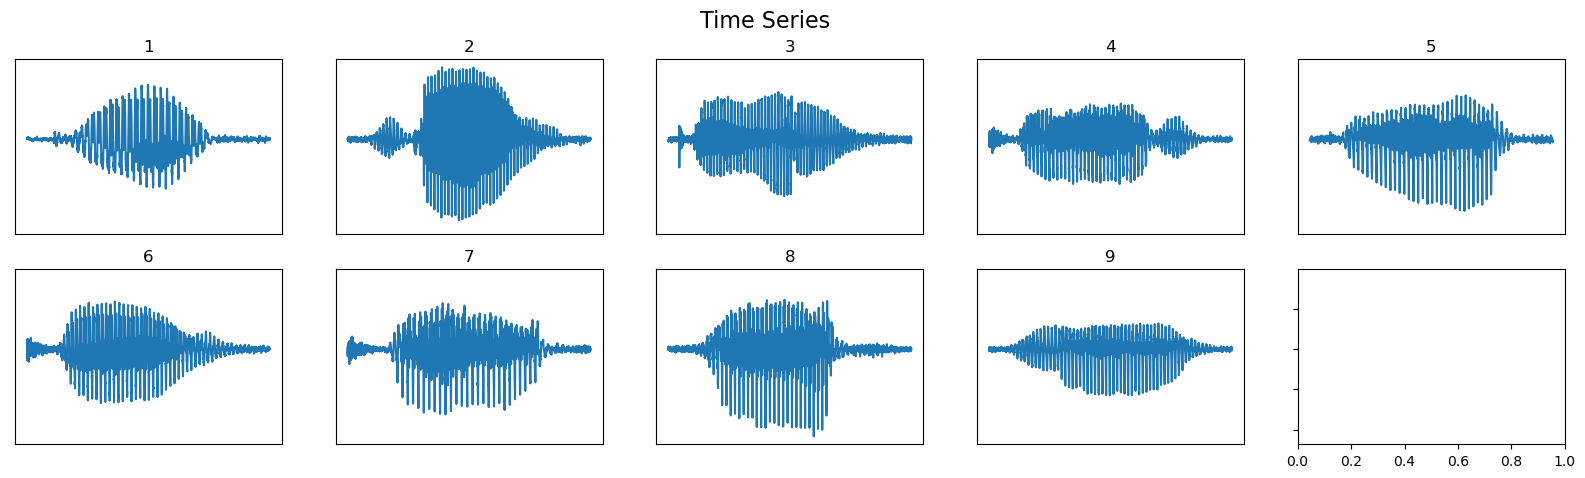

In [37]:
# Some have alot of noise begining and end of the signal and needs to be removed since there is no signal i.e. Noise threshold detection
plot_signals(signals)
plt.show()

### Plot the FFTs

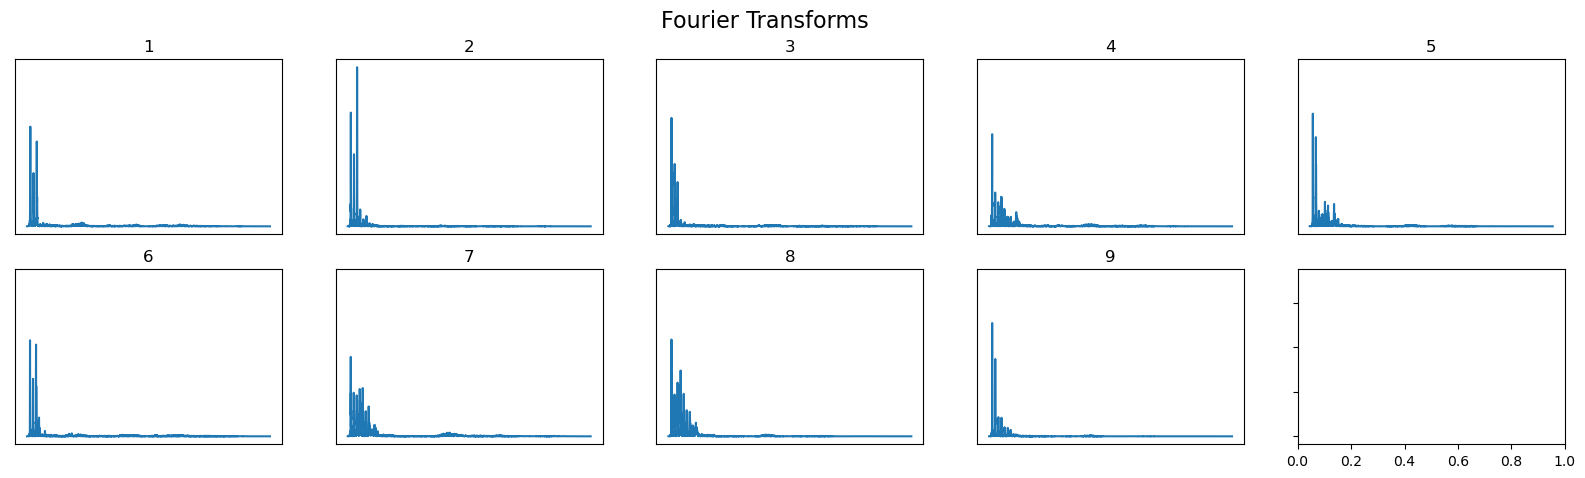

In [38]:
plot_fft(fft)
plt.show()

### Plot the Filter Banks

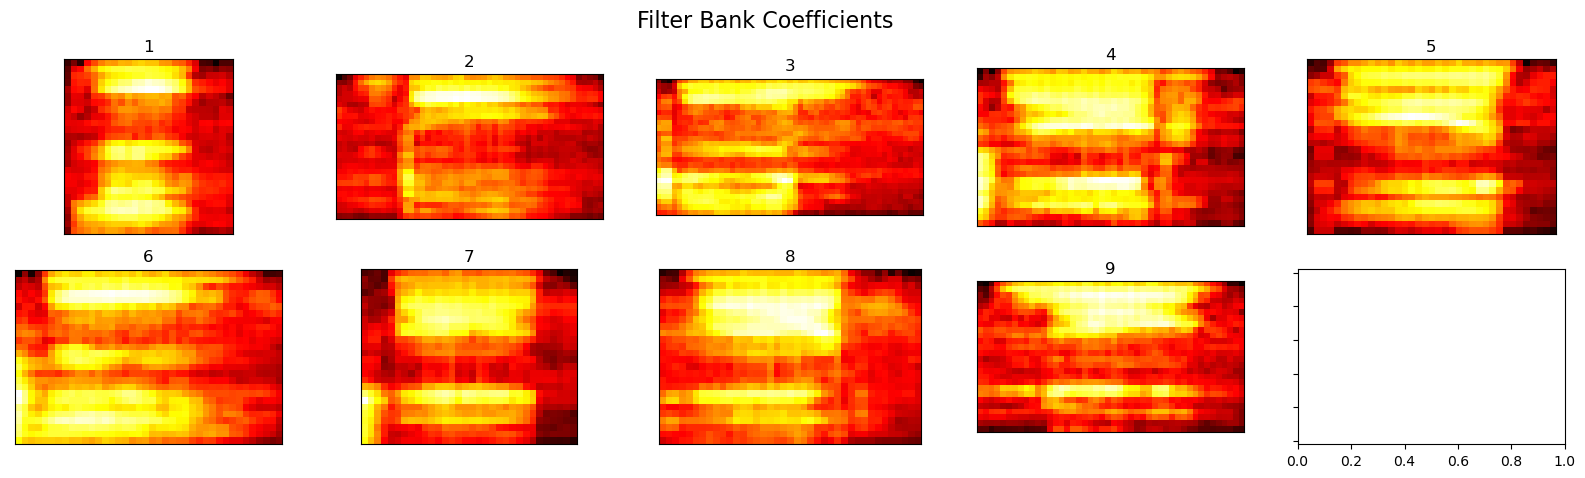

In [39]:
plot_fbank(fbank)
plt.show()

### Plot the MFCCs

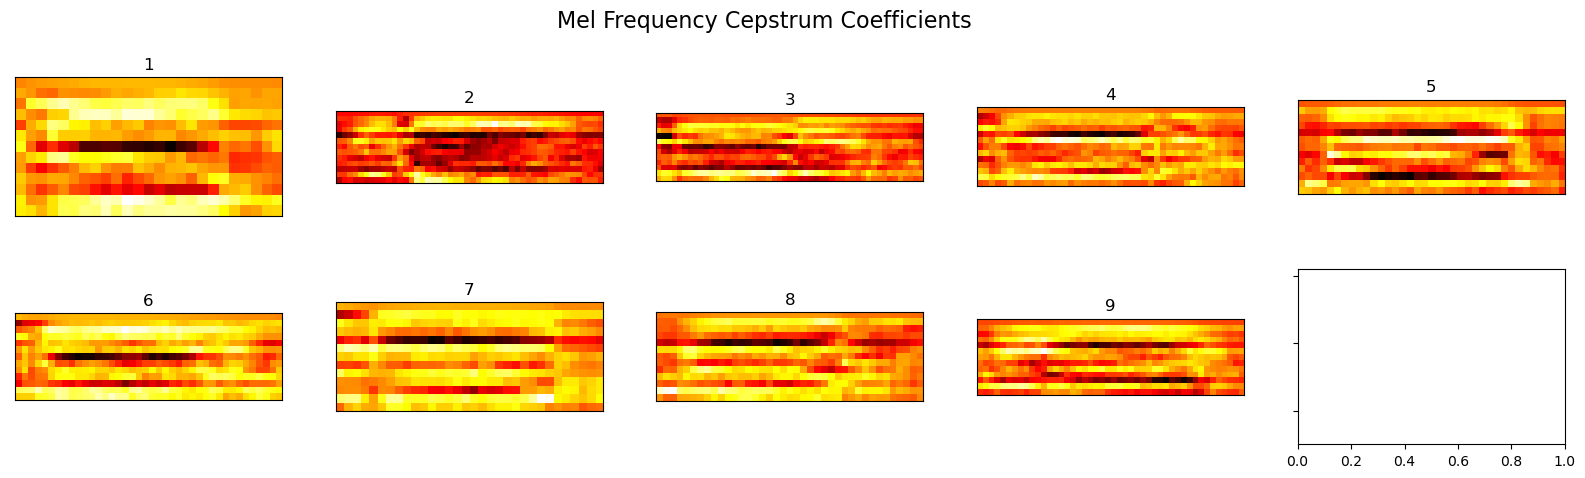

In [40]:
# When you do the Discrete Cosine Transform (DCT) on the filter banks, you get a more refined representation ready to be used
# for machine learning
plot_mfccs(mfccs)
plt.show()